# Evaluation: Evaluation + Erklärbarkeit

## Anforderungen an Projektumsetzung: Evaluation und Interpretation

Anforderungen:
- Setzen Sie die Aufgabenstellung für ein **Prädiktionsmodell** um -- wahlweise für Ihr Klassifikationsmodell oder Ihr Regressionsmodell aus den Anforderungen aus den entsprechenden Kapiteln.

- Definieren Sie für Ihr Modell die Frequenzbaseline bzw. die Mittelwertsbaseline.

- Definieren Sie für Ihr Modell eine einfache Vergleichsbaseline.
  
- Prüfen Sie mittels einer Lernkurve, ob Ihr Modell zu Over- oder Underfitting neigt und evaluieren Sie entsprechend des Ergebnisses ein mächtigeres oder weniger mächtiges Modell. Wenn Ihr Modell weder Over- noch Underfitting zeigt: Herzlichen Glückwunsch, es ist nichts weiter zu tun.

- Interpretieren Sie Ihr Modell: Entweder mit Hilfe von LIME oder bei transparenten Algorithmen aufgrund des gelernten Modells selber.

#### Laden der Bibliotheken & des Datensatzes

In [1]:
# Import der benötigten Bibliotheken

import importlib
import init_notebook

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import FunctionTransformer


In [2]:
importlib.reload(init_notebook)

dataset = init_notebook.get_final_dataset()

dataset = shuffle(dataset)

#### Setzen Sie die Aufgabenstellung für ein **Prädiktionsmodell** um -- wahlweise für Ihr Klassifikationsmodell oder Ihr Regressionsmodell aus den Anforderungen aus den entsprechenden Kapiteln.

Für die Evaluation wird das Klassifikationsmodell [softmax_model_final](Modelle/6_Klassifikation/softmax_model_final.joblib) aus 6_Klassifikation gewählt, da dort einige Experimente durchgeführt wurden und ein relativ guter Wert für die Vorhersage von Rauchern (Percision = 84%) erzielt wurde. 

#### Definieren Sie für Ihr Modell die Frequenzbaseline bzw. die Mittelwertsbaseline.

In [3]:
# Vorausgesagt wird lediglich, ob es sich um einen Nicht-Raucher ODER um einen Raucher/ehemaligen Raucher handelt.
# Deshalb werden die Klassen Raucher und ehemalige Raucher zusammengelegt: 

dataset['Raucher_Status'] = dataset['Raucher_Status'].replace(3,2)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns=['Raucher_Status']), dataset['Raucher_Status'], test_size=0.2, random_state=42)

X_train

,Geschlecht,Alter,Größe,Gewicht,Hüftumfang,Systolischer Blutdruck,Diastolischer Blutdruck,Nüchterner Blutzucker,Totale Cholesterin,HDL_Cholesterin,LDL_Cholesterin,Triglycerid,Hämoglobin,SGOT_AST,SGOT_ALT,gamma_GTP,Trinker,Body-Mass-Index
227265,0,45,155,55,77.0,120.0,84.0,90.0,248.0,56.0,176.0,82.0,14.0,23.0,15.0,11.0,0,22.89
416990,1,75,160,50,75.0,132.0,89.0,94.0,190.0,64.0,111.0,75.0,16.7,22.0,15.0,16.0,0,19.53
214207,1,25,165,60,72.0,117.0,67.0,82.0,180.0,30.0,96.0,269.0,16.2,109.0,28.0,15.0,1,22.04
857847,0,50,150,50,73.0,107.0,62.0,79.0,148.0,34.0,102.0,56.0,13.4,22.0,13.0,17.0,0,22.22
731033,1,45,175,85,94.0,125.0,76.0,119.0,175.0,51.0,87.0,187.0,13.7,26.0,17.0,18.0,1,27.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78496,1,70,170,70,95.0,112.0,62.0,105.0,136.0,39.0,65.0,159.0,16.1,24.0,19.0,49.0,0,24.22
705648,1,40,165,65,85.0,141.0,87.0,92.0,248.0,57.0,170.0,101.0,15.8,30.0,20.0,67.0,1,23.88
121315,1,40,180,75,91.5,108.0,72.0,95.0,247.0,53.0,155.0,195.0,15.5,16.0,23.0,20.0,1,23.15
766895,0,25,155,45,63.0,114.0,64.0,85.0,194.0,77.0,101.0,80.0,13.9,16.0,24.0,28.0,0,18.73


In [5]:
# Feature-Selektion wie in 6_Klassifikation:

sf_corr = X_train[['Geschlecht', 'Alter', 'Größe', 'Gewicht', 'Hüftumfang', 'Hämoglobin', 'gamma_GTP', 'Trinker']]

sf_corr_test = X_test[['Geschlecht', 'Alter', 'Größe', 'Gewicht', 'Hüftumfang', 'Hämoglobin', 'gamma_GTP', 'Trinker']]

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


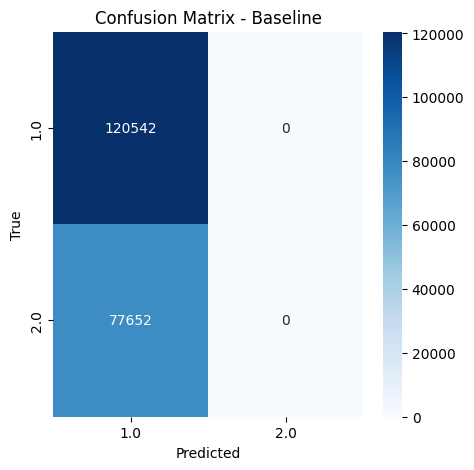

Accuracy (Baseline): 0.61
Precision (Baseline): 0.37
Recall (Baseline): 0.61
F1 score (Baseline): 0.46


In [6]:
# Erstelle ein DummyClassifier mit der Strategie 'most_frequent'
baseline_model = DummyClassifier(strategy='most_frequent')

# Trainiere das Basismodell
baseline_model.fit(sf_corr, y_train)

# Mache Vorhersagen auf dem Testset
y_pred_baseline = baseline_model.predict(sf_corr_test)

# Evaluationsmetriken berechnen
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
precision_baseline = precision_score(y_test, y_pred_baseline, average='weighted')
recall_baseline = recall_score(y_test, y_pred_baseline, average='weighted')
f1_baseline = f1_score(y_test, y_pred_baseline, average='weighted')

# Confusion Matrix erstellen und anzeigen
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=dataset['Raucher_Status'].unique(), yticklabels=dataset['Raucher_Status'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Baseline')
plt.show()

# Ausgabe der Metriken
print(f'Accuracy (Baseline): {accuracy_baseline:.2f}')
print(f'Precision (Baseline): {precision_baseline:.2f}')
print(f'Recall (Baseline): {recall_baseline:.2f}')
print(f'F1 score (Baseline): {f1_baseline:.2f}')

Durch die Funktion DummyClassifier(strategy='most_frequent') wird stets die am häufigsten vorkommende Klasse prädiziert, wodurch eine Frequenzbaseline geschaffen wird.

Das Ergebnis der Metriken dieses Modells ist deutlich schlechter als die Ergebnisse unseres Modells [softmax_model_final.joblib](Modelle/6_Klassifikation/softmax_model_final.joblib) aus 6_Klassifikation:

Accuracy: 0.83

Precision: 0.84

Recall weighted: 0.83

F1 score: 0.83

Es muss jedoch dazugesagt werden, dass sich die beiden Klassen sehr ähnlich verteilen (60 / 40), was es schwierig macht, bei einer Frequenzbasislinie gute Metriken zu erzielen. Diese wären noch schlechter, wenn wir die Frequenzbaseline auf den undergesampelten Daten erstellen würden, da hier das Konzept des stetigen Voraussagens der häufiger vorkommenden Zielklasse keinen Sinn ergeben würde.

#### Definieren Sie für Ihr Modell eine einfache Vergleichsbaseline.

Anstelle einer Pipeline folgt zunächst eine manuelle Initiaisierung.

Wie im Skript wird eine NB-Klassifikation genutzt, da wir die SoftmaxRegression auch zum Klassifizieren nutzten.

Als Features werden die selben wie beim Ausgangsmodell (bestes Modell) verwendet.

In [7]:
# Initialisierung des Naive Bayes-Klassifikators
nb_classifier = GaussianNB()

# Training des Modells
nb_classifier.fit(sf_corr, y_train)

# Vorhersage auf dem Testset
Y_pred = nb_classifier.predict(sf_corr_test)

# Evaluierung der Genauigkeit
accuracy = accuracy_score(y_test, Y_pred)

print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

         1.0       0.89      0.77      0.82    120542
         2.0       0.70      0.85      0.77     77652

    accuracy                           0.80    198194
   macro avg       0.79      0.81      0.80    198194
weighted avg       0.81      0.80      0.80    198194



Das Ergebnis der Vergleichsbasislinie ist zwar deutlich besser (weighted precision = 0.81, weighted recall = 0.8, weighted f1-score = 0.8) als das Ergebnis der Frequenzbaseline, allerdings schlechter als unser selbst trainiertes bestes Modell aus dem Notebook [6_Klassifikation](6_Klassifikation.ipynb).

Folgend wird eine weitere Vergleichsbasislinie erstellt, dieses Mal unter Verwendung einer Pipeline. 

In [8]:
# Erstellen der Pipeline:

baseline_pipeline = Pipeline(steps=[
                ('classifier', GaussianNB())])

baseline_pipeline.fit(sf_corr, y_train)

# Lerner auf den Testdaten evaluieren

dev_labels = baseline_pipeline.predict(sf_corr_test)

print(classification_report(y_test, dev_labels))

              precision    recall  f1-score   support

         1.0       0.89      0.77      0.82    120542
         2.0       0.70      0.85      0.77     77652

    accuracy                           0.80    198194
   macro avg       0.79      0.81      0.80    198194
weighted avg       0.81      0.80      0.80    198194



Mit der Pipeline erhalten wir dieselben Ergebnisse als bei der zuvor trainierten Vergleichsbaseline.

Deshalb wird folgend versucht, ein besseres Modell mit erneuter Feature-Extraktion über die SelectFromModel()-Funktion zu trainieren.

In [9]:
# Erstellen der Pipeline:

baseline_pipeline = Pipeline(steps=[
                ('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'), threshold='mean')),
                ('classifier', GaussianNB())])

baseline_pipeline.fit(X_train, y_train)

# Lerner auf den Testdaten evaluieren

dev_labels = baseline_pipeline.predict(X_test)

print(classification_report(y_test, dev_labels))

c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

         1.0       0.94      0.73      0.82    120542
         2.0       0.69      0.93      0.79     77652

    accuracy                           0.81    198194
   macro avg       0.81      0.83      0.80    198194
weighted avg       0.84      0.81      0.81    198194



Hier sind die Metriken besser als bei der zuvor trainierten Baseline. Vor allem die wweighted Precision mit dem Wert 0.84 sticht hierbei hervor. 

Diese ist nun ebenso gut wie in unserem Klassifikationsmodell aus dem Notebook [6_Klassifikation](6_Klassifikation.ipynb), jedoch sind die anderen Metriken schlechter.

Zudem gab es einen Fehler beim Konvergieren. Daher sind die Ergebnisse mit Vorsicht zu betrachten.

Interessant wäre nun, ob das so trainierte Modell durch undersampling besser wird, wie es in unserem Ursprungsmodell der Fall war. Deshalb werden nun die Trainings- und Testdaten durch Undersampling angepasst.

Random under-sampling:
Raucher_Status
1.0    388668
2.0    388668
Name: count, dtype: int64


<Axes: title={'center': 'Anzahl je Raucher_Status'}, xlabel='Raucher_Status'>

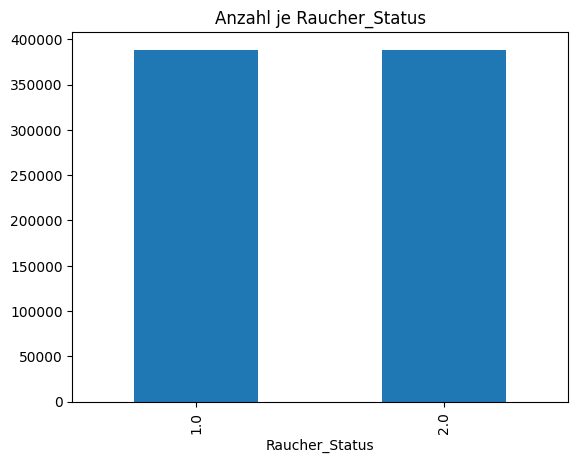

In [10]:
count_class_0, count_class_1 = dataset['Raucher_Status'].sort_values().value_counts()

# Aufteilen in Zielklassen

class_0 = dataset[dataset['Raucher_Status'] == 1]
class_1 = dataset[dataset['Raucher_Status'] == 2]

# Undersampling und darstellen der Zielklassen:

class_0_under = class_0.sample(count_class_1)
data_undersample = pd.concat([class_0_under, class_1], axis=0)

print('Random under-sampling:')
print(data_undersample['Raucher_Status'].value_counts())

data_undersample['Raucher_Status'].value_counts().plot(kind='bar', title='Anzahl je Raucher_Status')

In [11]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(data_undersample.drop(columns=['Raucher_Status']), data_undersample['Raucher_Status'], test_size=0.2, random_state=42)

X_train_under

,Geschlecht,Alter,Größe,Gewicht,Hüftumfang,Systolischer Blutdruck,Diastolischer Blutdruck,Nüchterner Blutzucker,Totale Cholesterin,HDL_Cholesterin,LDL_Cholesterin,Triglycerid,Hämoglobin,SGOT_AST,SGOT_ALT,gamma_GTP,Trinker,Body-Mass-Index
340277,0,60,155,55,82.5,115.0,67.0,101.0,197.0,56.0,106.0,178.0,13.7,33.0,38.0,27.0,0,22.89
363896,1,55,160,60,77.0,120.0,70.0,169.0,226.0,53.0,127.0,229.0,14.6,17.0,17.0,30.0,1,23.44
980513,0,25,160,50,67.5,127.0,85.0,83.0,196.0,92.0,89.0,72.0,13.8,20.0,15.0,18.0,1,19.53
707412,0,60,150,60,94.1,139.0,80.0,101.0,176.0,64.0,88.0,119.0,13.7,21.0,29.0,31.0,1,26.67
943039,0,60,150,50,77.0,110.0,70.0,88.0,165.0,64.0,81.0,104.0,13.7,17.0,13.0,14.0,0,22.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608719,0,30,160,50,63.3,138.0,76.0,111.0,218.0,93.0,111.0,67.0,11.8,22.0,10.0,11.0,1,19.53
183106,0,60,155,60,85.0,120.0,70.0,86.0,257.0,47.0,122.0,232.0,12.7,27.0,17.0,15.0,0,24.97
283085,0,55,150,55,72.0,140.0,80.0,103.0,259.0,59.0,189.0,51.0,12.8,22.0,25.0,19.0,0,24.44
744598,1,50,160,70,89.0,145.0,82.0,118.0,161.0,53.0,69.0,192.0,15.4,34.0,52.0,133.0,1,27.34


In [12]:
# Erstellen der Pipeline:

baseline_pipeline_under = Pipeline(steps=[
                ('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'), threshold='mean')),
                ('classifier', GaussianNB())])

baseline_pipeline_under.fit(X_train_under, y_train_under)

# Lerner auf den Testdaten evaluieren

dev_labels_under = baseline_pipeline_under.predict(X_test_under)

print(classification_report(y_test_under, dev_labels_under))

c:\Python312\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

         1.0       0.91      0.73      0.81     77520
         2.0       0.77      0.93      0.85     77948

    accuracy                           0.83    155468
   macro avg       0.84      0.83      0.83    155468
weighted avg       0.84      0.83      0.83    155468



In diesem Versuch ergeben sich dieselben Metriken wie in unserem Modell.

Dies zeigt zwar, dass ein Vergleichsmodell nicht genauer wird als unser Modell, jedoch gleich gut.

Es könnte sein, dass die Modelle nicht genug generalisiert sind, also ein Overfitting vorliegt. Dies wird im folgenden Abschnitt geprüft.

#### Prüfen Sie mittels einer Lernkurve, ob Ihr Modell zu Over- oder Underfitting neigt und evaluieren Sie entsprechend des Ergebnisses ein mächtigeres oder weniger mächtiges Modell. Wenn Ihr Modell weder Over- noch Underfitting zeigt: Herzlichen Glückwunsch, es ist nichts weiter zu tun.

Zunächst laden wir unser Dataset neu, shuffeln und teilen die Daten auf.

Zudem trainieren wir unser Modell mit denselben Parametern neu, um sicherzustellen, dass die Testdaten dem Modell tatsächlich noch unbekannt sind.

In [13]:
# Dataset neu laden:

importlib.reload(init_notebook)

dataset = init_notebook.get_final_dataset()

dataset = shuffle(dataset)

# Gleichsetzen der Raucherstati 2 und 3:

dataset['Raucher_Status'] = dataset['Raucher_Status'].replace(3,2)

count_class_0, count_class_1 = dataset['Raucher_Status'].sort_values().value_counts()

# Aufteilen in Zielklassen und undersampling:

class_0 = dataset[dataset['Raucher_Status'] == 1]
class_1 = dataset[dataset['Raucher_Status'] == 2]

class_0_under = class_0.sample(count_class_1)
data_undersample = pd.concat([class_0_under, class_1], axis=0)


# Feature-Selektion wie in unserem Modell:

feature_dataset = data_undersample[['Geschlecht', 'Alter', 'Größe', 'Gewicht', 'Hüftumfang', 'Hämoglobin', 'gamma_GTP', 'Trinker', 'Raucher_Status']]

In [14]:
# Trainings- und Entwicklungsdaten vorbereiten:

X_train, X_test, y_train, y_test = train_test_split(feature_dataset.drop(columns=['Raucher_Status']), feature_dataset['Raucher_Status'], test_size=0.2, random_state=42)

X_train

,Geschlecht,Alter,Größe,Gewicht,Hüftumfang,Hämoglobin,gamma_GTP,Trinker
289193,1,50,165,70,83.0,16.0,27.0,0
368751,1,40,170,70,77.0,13.8,29.0,1
239929,0,75,145,50,83.0,13.1,17.0,0
635039,0,55,150,50,76.0,12.7,19.0,1
751666,1,45,175,85,92.0,15.9,65.0,0
...,...,...,...,...,...,...,...,...
381645,0,25,155,60,76.0,14.0,42.0,0
623679,0,70,155,60,92.0,11.4,15.0,0
458616,0,30,160,65,73.5,12.8,11.0,1
736638,1,45,160,70,93.8,16.9,60.0,0


In [15]:
# Modell neu trainieren: 

softmax_model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000)
softmax_model.fit(X_train, y_train)


# Vorhersagen auf dem Testset machen (nur für die selektierten Features)

y_pred_model_undersample = softmax_model.predict(X_test)

# Accuracy berechnen:

accuracy = accuracy_score(y_test, y_pred_model_undersample)
print(f'Accuracy: {accuracy:.2f}')

# Precision berechnen:

precision = precision_score(y_test, y_pred_model_undersample, average='weighted')
print(f'Precision: {precision:.2f}')

# Recall berechnen:

recall = recall_score(y_test, y_pred_model_undersample, average='weighted')
print(f'Recall weighted: {recall:.2f}')

# F1 Score berechnen:

f1 = f1_score(y_test, y_pred_model_undersample, average='weighted')
print(f'F1 score: {f1:.2f}')

Accuracy: 0.83
Precision: 0.84
Recall weighted: 0.83
F1 score: 0.83


Nun können die Lernkurven des Modells dargestellt werden. 

c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


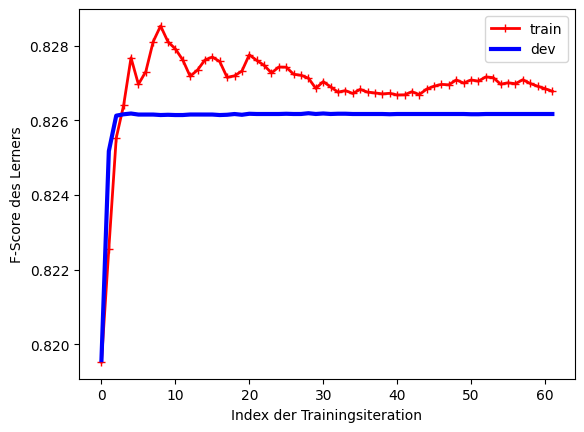

In [16]:
# Lernkurve plotten (in 10.000-er Schritten, da der Datensatz sehr groß ist und kleinere Schritte zu einem Timeout führen):

importlib.reload(init_notebook)
init_notebook.plot_learning_curves(softmax_model, X_train, y_train, X_test, y_test, 10000)

Die Ausgabe der Lernkurven wurde auf Grund der langen Laufzeit (ca. 100 Minuten) persistiert. [Logs_Lernkurve_1](Logs/9_Evaluation-Interpretation/Logs_Lernkurve_1.png)

Daraus wird ersichtlich, dass weder Over- noch Underfitting vorherrscht:

> Liegen die Maximalwerte nah beieinander und der Maximalwert ist auch noch relativ niedrig (im Vergleich zu den Baselines), liegt wahrscheinlich Underfitting vor.

Die Maximalwerte liegen zwar nahe beieinander (~ 0.1 Prozentpunkte Differenz), jedoch sind diese in Relation zu den Baselines nicht niedrig (F1-Score etwa 0.3 bis 0.4 Prozentpunkte geringer als bei unserer besten Vergleichsbaseline (83 %)). 

> Ein Modell, das auf den Trainingsdaten wenig Fehler macht, aber auf den Entwicklungsdaten konsistent deutlich schlechter abschneidet, zeigt eher Overfitting.

Da der Unterschied zwischen den Trainungs- und Entwicklungsdaten nicht wesentlich ist, liegt auch kein Overfitting vor.



Die Grafik zeigt zudem, dass das Modell ab der 9. Iteration nicht mehr genauer wird. Das bedeuetet, dass das Modell beim Training mit den ersten 80.000 Zeilen am genausten ist.

#### Interpretieren Sie Ihr Modell: Entweder mit Hilfe von LIME oder bei transparenten Algorithmen aufgrund des gelernten Modells selber.

Da unser Modell transparent ist, wird keine Interpretation mit LIME benötigt.

Stattdessen interpretieren wir das Modell anhand der bereits gemachten Vergleiche, Evaluationen und Metriken.

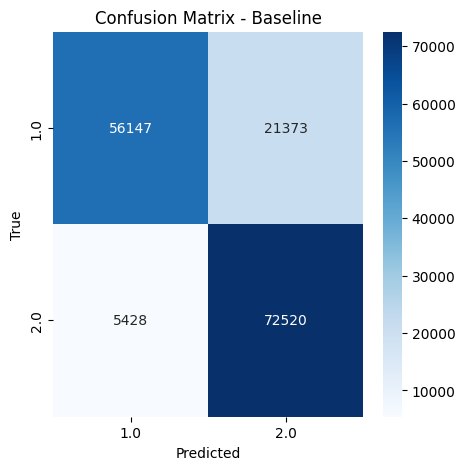

Accuracy (Baseline): 0.83
Precision (Baseline): 0.84
Recall (Baseline): 0.83
F1 score (Baseline): 0.83


In [201]:
# Laden des Modells:

softmax_model = joblib.load('Modelle/6_Klassifikation/softmax_model_final.joblib')

# Mache Vorhersagen auf dem Testset
y_pred = softmax_model.predict(X_test)

# Evaluationsmetriken berechnen
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Confusion Matrix erstellen und anzeigen
cm_baseline = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=dataset['Raucher_Status'].unique(), yticklabels=dataset['Raucher_Status'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Baseline')
plt.show()

# Ausgabe der Metriken
print(f'Accuracy (Baseline): {accuracy:.2f}')
print(f'Precision (Baseline): {precision:.2f}')
print(f'Recall (Baseline): {recall:.2f}')
print(f'F1 score (Baseline): {f1:.2f}')

Durch den Vergleich unseres Modells zu den Baselines und auch zu den Modellen auf Kaggle konnte festgestellt werden, dass dieses kaum genauer werden kann als es aktuell ist.

Die Confusion-Matrix zeigt, dass falsche Voraussagen tendenziell eher bei Raucherstatus True = 1 & Predicted = 2 auftauchen. Das bedeutet, dass vorausgesagt wird, dass ein Proband Raucher oder ehemaliger Raucher ist, obwohl er nicht raucht und nie geraucht hat. 

Es muss daher bei der Auswertung stets im Hinterkopf behalten werden, dass das Modell nicht perfekt ist und die Ausgaben kritisch hinterfragt werden müssen, da lediglich eine Genauigkeit von rund 83 % vorherrscht. 

Aus dem vorherigen Abschnitt ist zu sehen, dass das Modell weder zu Over-, noch zu Underfitting neigt und somit bedenkenlos auf neue Daten angewandt werden kann.

Es scheint, als wäre das Rauschen in den Daten durch das Undersampling vor dem Training des Modells reduziert worden.